# NeuralForecast Cross-Validation Workflow Test

This notebook adapts the probabilistic forecasting workflow using `cross_validation` to our NHITS model and dataset.


In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MQLoss
from utilsforecast.losses import mae, rmse
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
import warnings
warnings.filterwarnings('ignore')


/Users/danherman/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-20 14:46:33,562	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-20 14:46:34,880	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# 2. Load and Preprocess Data
# Load the mini dataset used for local testing
df = pd.read_csv('local_test_data/mini_data.csv')

# Ensure datetime
if 'ds' in df.columns:
    df['ds'] = pd.to_datetime(df['ds'])

# Ensure unique_id exists
if 'unique_id' not in df.columns:
    df['unique_id'] = 'E'

# Ensure data is sorted by time
df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)

print(f"Data shape: {df.shape}")
df.head()


Data shape: (1999, 16)


,ds,duration,y,dow,temp,precip,snow,snowdepth,visibility,windspeed,rolling_std_50,rolling_max_10,rolling_mean_10,rolling_std_10,rolling_mean_50,unique_id
0,2024-01-01 00:49:29+00:00,26.87,15.40,0,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698,E
1,2024-01-01 01:02:10+00:00,28.02,12.68,0,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698,E
2,2024-01-01 01:17:55+00:00,31.92,15.75,0,42.2,0.0,0.0,0.0,9.9,6.9,7.643376,28.1,14.783,5.937839,16.3698,E
3,2024-01-01 01:34:17+00:00,31.03,16.37,0,42.2,0.0,0.0,0.0,9.9,5.0,7.643376,28.1,14.783,5.937839,16.3698,E
4,2024-01-01 02:02:23+00:00,42.05,28.10,0,42.2,0.0,0.0,0.0,9.9,5.0,7.643376,28.1,14.783,5.937839,16.3698,E


In [7]:
# 3. Load Pre-trained Model
# We load the model trained by the container test
model_dir = 'local_test_artifacts/nhits_model'
nf = NeuralForecast.load(path=model_dir)
print("Model loaded successfully.")

# Inspect model configuration
model = nf.models[0]
print(f"Model: {model}")
print(f"Input Size: {model.input_size}")
print(f"Horizon: {model.h}")
print(f"Loss: {model.loss}")

# FIX: Disable logger to avoid "Missing folder" error from old temp paths
# The loaded model points to a temp dir that doesn't exist anymore.
if hasattr(model, 'trainer_kwargs'):
    model.trainer_kwargs['logger'] = False
    model.trainer_kwargs['enable_checkpointing'] = False
    # Ensure accelerator is set correctly for local test
    import torch
    model.trainer_kwargs['accelerator'] = 'gpu' if torch.cuda.is_available() else 'cpu'
    
    # FIX: Remove EarlyStopping callback which causes error when refit=False
    # because 'ptl/val_loss' is not produced during inference-only CV.
    if 'callbacks' in model.trainer_kwargs:
        model.trainer_kwargs['callbacks'] = []

# Clear existing logger instance if any
if hasattr(model, '_logger'):
    model._logger = None

# Clear trainer reference so it re-initializes
if hasattr(model, '_trainer'):
    model._trainer = None


Seed set to 1


Model loaded successfully.
Model: NHITS
Input Size: 160
Horizon: 1
Loss: MQLoss()


In [8]:
# 4. Perform Cross-Validation
# We want to evaluate on the last 20% of the data
total_rows = len(df)
test_size = int(total_rows * 0.2)
print(f"Test Size (n_windows): {test_size}")

# Run Cross Validation
# step_size=1 means we predict the next step, then move the window by 1 step, and predict again.
# This simulates the rolling forecast loop.
cv_df = nf.cross_validation(
    df=df,
    n_windows=test_size,
    step_size=1,
    refit=False
)

print("Cross Validation completed.")
cv_df.head()


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Test Size (n_windows): 399


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MQLoss        │      3 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  4.3 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 4.3 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.3 M                                                                                                
Total estimated model params size (MB): 17                                                                         
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

`Trainer.fit` stopped: `max_steps=1000` reached.


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Cross Validation completed.


,unique_id,ds,cutoff,NHITS-lo-80.0,NHITS-median,NHITS-hi-80.0,y
0,E,2024-01-10 17:46:42+00:00,2024-01-10 17:39:11+00:00,7.341277,7.440482,7.486533,7.52
1,E,2024-01-10 17:55:55+00:00,2024-01-10 17:46:42+00:00,9.708402,9.753206,9.834919,9.22
2,E,2024-01-10 18:22:31+00:00,2024-01-10 17:55:55+00:00,20.307911,20.318865,20.404516,26.60
3,E,2024-01-10 18:25:21+00:00,2024-01-10 18:22:31+00:00,6.055458,6.319638,6.554413,2.83
4,E,2024-01-10 18:31:47+00:00,2024-01-10 18:25:21+00:00,4.162544,4.270349,4.316341,5.53


In [9]:
# 5. Post-process Results
# Rename columns to match evaluation expectations if needed
# Our model outputs: NHITS-median, NHITS-lo-90, NHITS-hi-90 (based on quantiles 0.1, 0.5, 0.9)
# Let's inspect columns first
print(f"Columns: {cv_df.columns}")

# Rename median to model name for simplicity in evaluation
cv_df = cv_df.rename(columns={'NHITS-median': 'NHITS'})
cv_df.head()


Columns: Index(['unique_id', 'ds', 'cutoff', 'NHITS-lo-80.0', 'NHITS-median',
       'NHITS-hi-80.0', 'y'],
      dtype='object')


,unique_id,ds,cutoff,NHITS-lo-80.0,NHITS,NHITS-hi-80.0,y
0,E,2024-01-10 17:46:42+00:00,2024-01-10 17:39:11+00:00,7.341277,7.440482,7.486533,7.52
1,E,2024-01-10 17:55:55+00:00,2024-01-10 17:46:42+00:00,9.708402,9.753206,9.834919,9.22
2,E,2024-01-10 18:22:31+00:00,2024-01-10 17:55:55+00:00,20.307911,20.318865,20.404516,26.60
3,E,2024-01-10 18:25:21+00:00,2024-01-10 18:22:31+00:00,6.055458,6.319638,6.554413,2.83
4,E,2024-01-10 18:31:47+00:00,2024-01-10 18:25:21+00:00,4.162544,4.270349,4.316341,5.53


In [10]:
# 6. Evaluate Performance
# Define metrics
metrics = [mae, rmse]

# Evaluate
evaluation = evaluate(
    cv_df.drop(columns=['cutoff'], errors='ignore'),
    metrics=metrics,
    models=['NHITS']
)

# Aggregate results
evaluation_summary = evaluation.drop(columns=['unique_id']).groupby('metric').mean().reset_index()
print(evaluation_summary)


  metric     NHITS
0    mae  1.244209
1   rmse  1.958810


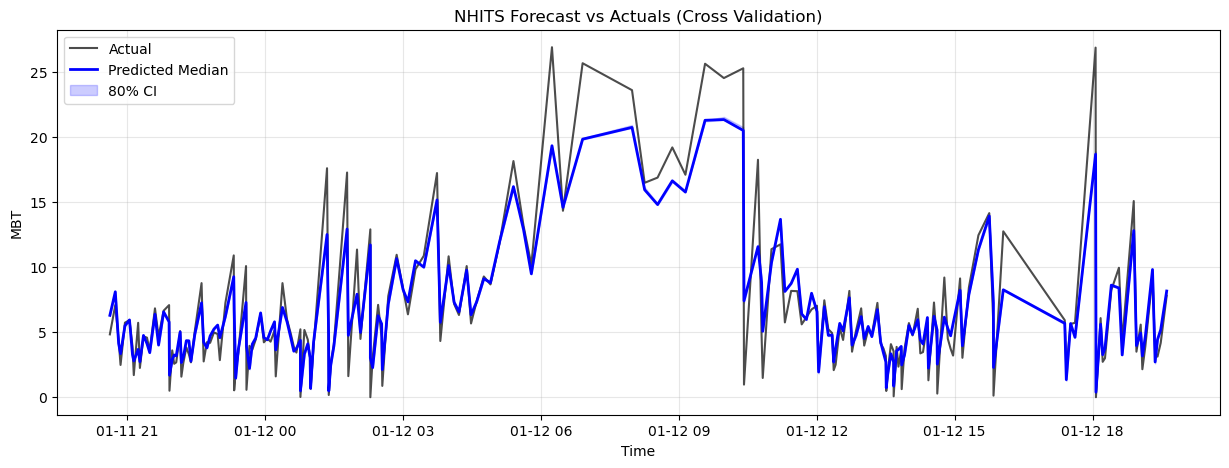

In [11]:
# 7. Visualize Forecasts
# Plot the last 200 points
plot_df = cv_df.tail(200)

plt.figure(figsize=(15, 5))
plt.plot(plot_df['ds'], plot_df['y'], label='Actual', color='black', alpha=0.7)
plt.plot(plot_df['ds'], plot_df['NHITS'], label='Predicted Median', color='blue', linewidth=2)

# Plot Confidence Interval (80%)
# We used quantiles 0.1 and 0.9, which correspond to the 80% interval
if 'NHITS-lo-80.0' in plot_df.columns and 'NHITS-hi-80.0' in plot_df.columns:
    plt.fill_between(plot_df['ds'], plot_df['NHITS-lo-80.0'], plot_df['NHITS-hi-80.0'], color='blue', alpha=0.2, label='80% CI')
elif 'NHITS-lo-90' in plot_df.columns and 'NHITS-hi-90' in plot_df.columns: # Check for alternative naming
     plt.fill_between(plot_df['ds'], plot_df['NHITS-lo-90'], plot_df['NHITS-hi-90'], color='blue', alpha=0.2, label='80% CI')


plt.title('NHITS Forecast vs Actuals (Cross Validation)')
plt.xlabel('Time')
plt.ylabel('MBT')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
